# Explore run dc2_object_run2.2i_dr6_wfd_prev2 

- author : Sylvie Dagoret-Campagne
- affliliation : IJCLab/in2p3/CNRS

- creation date : January 30th 2021

- Run on Spark cluster


In [2]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import pyarrow

In [4]:
pyarrow.__version__

'0.14.1'

In [5]:
#from pyspark import SparkContext
#import pyspark
#sc = SparkContext (
#   "local", 
#   "storagelevel app"
#)

In [6]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=mesos://vm-75063.lal.in2p3.fr:5050 appName=PySparkShell>
2.4.4


In [7]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [8]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [9]:
npix = hp.nside2npix(nside)
lmax = 3 * nside

In [10]:
def Ang2Pix_func(ra: pd.Series, dec: pd.Series) -> pd.Series:
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [11]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
#gal = gal.withColumn("ihealpix",pd_ang2pix(gal["RA"],gal["DEC"]))

## Get parquet files


In [13]:
! hadoop dfs -ls /lsst/DC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 22 items
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-06-12 10:23 /lsst/DC2/DR6axCdc2.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-12-11 12:11 /lsst/DC2/cosmoDC2
-rw-r--r--   3 stephane.plaszczynski lsst 83486737444 2020-05-28 19:33 /lsst/DC2/dc2_object_run2.2i_dr3.parquet
-rw-r--r--   3 stephane.plaszczynski lsst 44384598496 2020-06-05 13:15 /lsst/DC2/dc2_object_run2.2i_dr6.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2021-01-06 01:06 /lsst/DC2/dc2_object_run2.2i_dr6_wfd_prev2
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-10-07 20:49 /lsst/DC2/dc2_object_run2.2i_dr6_wfd_v1
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-06-26 10:36 /lsst/DC2/dc2_object_run2.2i_dr6b
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-07-28 18:46 /lsst/DC2/dc2_object_run2.2i_dr6c
drwxr-xr-x   - stephane.plasz

### Read files with spark

In [14]:
datafile="/lsst/DC2/dc2_object_run2.2i_dr6_wfd_prev2"

In [15]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

In [16]:
df = spark.read.format("parquet").load(datafile)     

In [17]:
df = df.repartition(df.rdd.getNumPartitions())

### DC2 Object catalog Schema

In [18]:
# Check what we have in the file
df.printSchema()

root
 |-- I_flag: boolean (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- I_flag_i: boolean (nullable = true)
 |-- I_flag_r: boolean (nullable = true)
 |-- I_flag_u: boolean (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- IxxPSF_pixel: double (nullable = true)
 |-- IxxPSF_pixel_g: double (nullable = true)
 |-- IxxPSF_pixel_i: double (nullable = true)
 |-- IxxPSF_pixel_r: double (nullable = true)
 |-- IxxPSF_pixel_u: double (nullable = true)
 |-- IxxPSF_pixel_y: double (nullable = true)
 |-- IxxPSF_pixel_z: double (nullable = true)
 |-- Ixx_pixel: double (nullable = true)
 |-- Ixx_pixel_g: double (nullable = true)
 |-- Ixx_pixel_i: double (nullable = true)
 |-- Ixx_pixel_r: double (nullable = true)
 |-- Ixx_pixel_u: double (nullable = true)
 |-- Ixx_pixel_y: double (nullable = true)
 |-- Ixx_pixel_z: double (nullable = true)
 |-- IxyPSF_pixel: double (nullable = true)
 |-- IxyPSF_pixel_g: double (nullable = true)
 

# Select Galaxies

In [20]:
df_gal=df.filter('extendedness == true')

In [21]:
# Show all available tracts
df_gal.select('tract').distinct().show()

+-----+
|tract|
+-----+
| 2906|
| 3452|
| 3081|
| 3640|
| 2900|
| 4028|
| 4235|
| 4636|
| 2724|
| 3634|
| 3076|
| 3636|
| 4639|
| 4859|
| 3258|
| 4229|
| 4436|
| 4034|
| 4231|
| 3828|
+-----+
only showing top 20 rows



# Get a track and show the 2D plot

## utilisation de select / where /collect

Text(0, 0.5, 'dec [deg]')

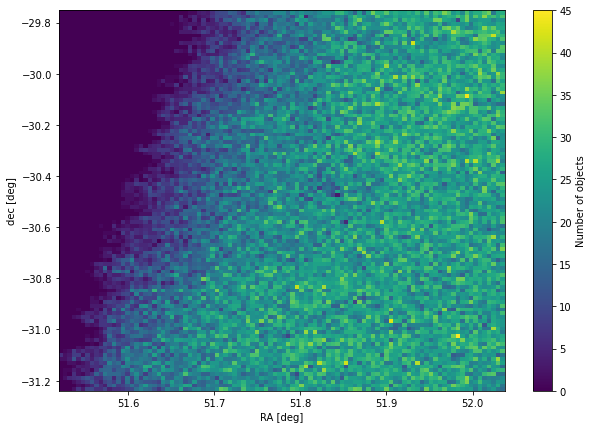

In [22]:
mydata=df_gal.select('ra','dec').where('tract==4636').collect()
# 'collect' return a list of [ra,dec]
ra,dec=np.transpose(mydata)

# Plot a 2D histogram of sources
plt.figure(figsize=(10,7))
plt.hist2d(ra,dec,100)
#plt.gca().set_aspect('equal')
plt.colorbar(label="Number of objects")
plt.xlabel('RA [deg]')
plt.ylabel('dec [deg]')

## Avec SQL

In [23]:
# Pure SQL
cols = "ra,dec"

# SQL - register first DataFrame
df_gal.createOrReplaceTempView('full_tract')


# Keep only columns with 0 < magerr_g < 0.3

sql_command = """
     SELECT {}
     from full_tract
     WHERE
           tract == 4034
""".format(cols)

# Execute the expression - return a dataframe

df_sub=spark.sql(sql_command)
mydata = df_sub.collect()

## Spark DataFrame build-in methods

In [24]:
# using select,where
mydata=df.select('ra','dec').where('tract==4030').collect()

# or using select/filter
mydata=df.select('ra','dec').filter('tract==4030').collect()

## Data type

The data returned by collecting a DataFrame (collect) in Spark is structured as a native Python list of Row

In [25]:
print("Data type is {}".format(type(mydata[0])))

Data type is <class 'pyspark.sql.types.Row'>


In [26]:
print("Data example is {}".format(mydata[0]))

Data example is Row(ra=64.41754020415338, dec=-34.51705001164893)


## can convert the Pyspark SQL Row into a numpy array 

In [ ]:
#arow=data[0]

In [ ]:
#mylist=list(arow)

In [ ]:
#print("Input type  {} / Output type {} ".format(type(arow),type(mylist)))

## Implicit conversion into numpy array

In [ ]:
#cols = np.transpose(arow)

In [ ]:
#print("Input type  {} / Output type {} ".format(type(arow),type(cols)))

## Spark to Pandas DataFrame

In [27]:
pdata=df_gal.select('ra','dec').where('tract=4034').toPandas()
pdata.head()

,ra,dec
0,72.181780,-35.342764
1,71.357468,-34.683183
2,70.946182,-35.656499
3,71.814706,-34.874650
4,72.422098,-34.754523


## Access time

In [28]:
df_radec=df_gal.select('ra','dec')
%time mydata = df_radec.where('tract==4430').collect()

CPU times: user 2.54 s, sys: 166 ms, total: 2.7 s
Wall time: 7.82 s


In [ ]:
# need more executors
#%time mydata = df_radec.collect()

## Count

In [29]:
%time mydata = df_radec.where('tract==4430').count()

CPU times: user 126 ms, sys: 49.2 ms, total: 176 ms
Wall time: 7.17 s


In [30]:
%time mydata = df_radec.count()

CPU times: user 2.19 ms, sys: 3.31 ms, total: 5.5 ms
Wall time: 7.83 s


## Applying filters and cuts

In [31]:
df_cut=df_radec.where('tract==4430 AND good')
df_full=df_radec.where('tract==4430')

In [32]:
print("Number of sources before cut : {}".format(df_full.count()))

Number of sources before cut : 873954


In [33]:
print("Number of sources after cut : {}".format(df_cut.count()))

Number of sources after cut : 872850


## Plot the results in the standard way

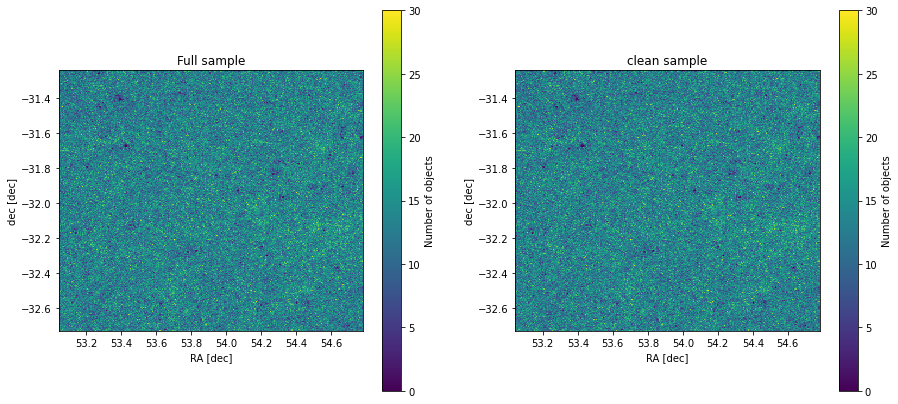

In [34]:
plt.figure(figsize=(15,7))

for index, dataframe in enumerate([df_full,df_cut]):
    ra,dec=np.transpose(dataframe.collect())
    plt.subplot(121+index)
    (count,xe,ye,Image)=plt.hist2d(ra,dec,256);
    plt.gca().set_aspect('equal');
    plt.xlabel('RA [dec]');
    plt.ylabel('dec [dec]');
    if index ==0:
        plt.title('Full sample');
    else:
        plt.title('clean sample');
        
    plt.colorbar(label="Number of objects");

**Spark point of view: distribute the computation (and plot!)**

The way to be faster is to distribute the plot (or the computation which leads to the data to be plotted).
Histograms are particularly easy to distribute. Let's write a method to be apply on each Spark partition (each would contain only a fraction of the data):

In [35]:
def hist2d(partition, nbins=256, xyrange=None):
    """ Produce 2D histograms from (x, y) data
    
    Parameters
    ----------
    partition : Iterator
        Iterator containing partition data *[x, y].
        
    Returns
    ----------
    Generator yielding counts for each partition. 
    Counts is an array of dimension nbins x nbins.
    """
    # Unwrap the iterator
    radec = [*partition]
    ra, dec = np.transpose(radec)
    
    (counts, xedges, yedges, Image) = plt.hist2d(
        ra, dec, nbins, 
        range=xyrange)
    
    yield counts

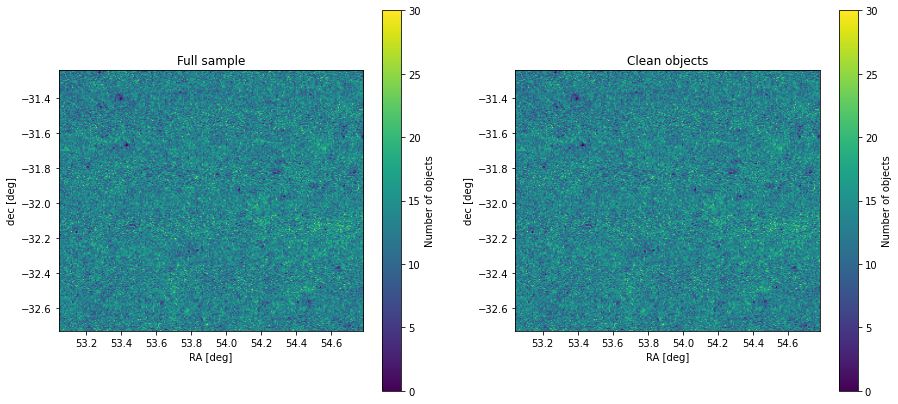

In [36]:
# Min/Max values - just to make a nice plot
xyrange = [[np.min(xe), np.max(xe)], [np.min(ye), np.max(ye)]]

plt.figure(figsize=(15, 7))
for index, dataframe in enumerate([df_full, df_cut]):
    plt.subplot(121 + index)
    # This is the crucial part - build the plot data in parallel!
    im = dataframe\
        .rdd\
        .mapPartitions(lambda partition: hist2d(partition, 256, xyrange))\
        .reduce(lambda x, y: x+y)
    
    plt.imshow(im.T, origin='lower' ,extent=np.array(xyrange).flatten(),aspect='equal');
    plt.xlabel('RA [deg]');
    plt.ylabel('dec [deg]');
    if index == 0:
        plt.title('Full sample');
    else:
        plt.title('Clean objects');
    plt.colorbar(label='Number of objects');

In [37]:
np.array(xyrange).flatten()

array([ 53.04348056,  54.78260365, -32.72727263, -31.23967398])

## Time access

In [38]:
%time data = df_cut.collect()

CPU times: user 2.78 s, sys: 100 ms, total: 2.88 s
Wall time: 3.47 s


In [39]:
%time data = df_cut.rdd.mapPartitions(lambda partition: hist2d(partition, xyrange)).reduce(lambda x, y: x+y)

CPU times: user 196 ms, sys: 84.4 ms, total: 280 ms
Wall time: 4.32 s


# Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the [`CModel` magnitude](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel) is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B) section 4.9.10

**Note** JP writing: I couldn't find the counterpart of `{band}_modelfit_CModel_flux` in dpdd files. So just for the sake of the exercise, I used `magerr_{band}_cModel`.

In [42]:
df.printSchema()

root
 |-- I_flag: boolean (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- I_flag_i: boolean (nullable = true)
 |-- I_flag_r: boolean (nullable = true)
 |-- I_flag_u: boolean (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- IxxPSF_pixel: double (nullable = true)
 |-- IxxPSF_pixel_g: double (nullable = true)
 |-- IxxPSF_pixel_i: double (nullable = true)
 |-- IxxPSF_pixel_r: double (nullable = true)
 |-- IxxPSF_pixel_u: double (nullable = true)
 |-- IxxPSF_pixel_y: double (nullable = true)
 |-- IxxPSF_pixel_z: double (nullable = true)
 |-- Ixx_pixel: double (nullable = true)
 |-- Ixx_pixel_g: double (nullable = true)
 |-- Ixx_pixel_i: double (nullable = true)
 |-- Ixx_pixel_r: double (nullable = true)
 |-- Ixx_pixel_u: double (nullable = true)
 |-- Ixx_pixel_y: double (nullable = true)
 |-- Ixx_pixel_z: double (nullable = true)
 |-- IxyPSF_pixel: double (nullable = true)
 |-- IxyPSF_pixel_g: double (nullable = true)
 

In [43]:
# Subset of columns of interest
cols = "mag_g_cModel, mag_r_cModel, mag_i_cModel"

# SQL - register first the DataFrame
df.createOrReplaceTempView("full_tract")

# Used to be g_modelfit_CModel_flux
sql_command = """
    SELECT {}
    FROM full_tract 
    WHERE 
        tract == 4636 AND
        clean AND
        magerr_g_cModel>0 AND
        magerr_g_cModel<1e16 AND
        magerr_r_cModel>0 AND
        magerr_r_cModel<1e16 AND
        magerr_i_cModel>0 AND
        magerr_i_cModel<1e16
""".format(cols)

# Execute the expression - return a DataFrame
df_sub = spark.sql(sql_command)

print(df_sub.count())

207949


So now, we have selected what we think are stars. Let's take a look at the colors of these objects

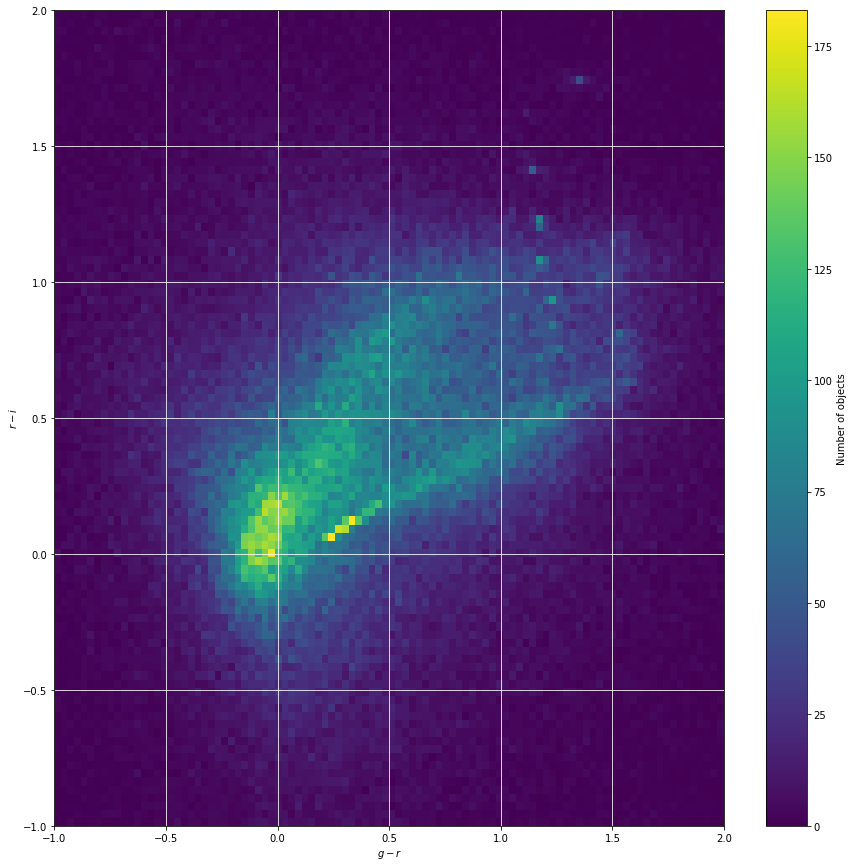

In [44]:
plt.figure(figsize=(15, 15))
mag_g_cModel, mag_r_cModel, mag_i_cModel = np.transpose(df_sub.collect())
plt.hist2d(mag_g_cModel - mag_r_cModel,
           mag_r_cModel - mag_i_cModel, 
           bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')
plt.colorbar(label='Number of objects');
plt.grid(color="w")

# GroupBy

In [45]:
df_stat=df_gal.groupBy("tract").count()

In [47]:
df_stat.show()

+-----+------+
|tract| count|
+-----+------+
| 2906|761182|
| 3452|785896|
| 3081|828969|
| 3640|803361|
| 2900|814598|
| 4028|833885|
| 4235|791681|
| 4636|173107|
| 2724|   177|
| 3634|862612|
| 3076|819004|
| 3636|869495|
| 4639|845713|
| 4859|806074|
| 3258|836615|
| 4229|861909|
| 4436|799418|
| 4231|834705|
| 4034|776378|
| 2908|693791|
+-----+------+
only showing top 20 rows



In [48]:
dp_stat=df_stat.toPandas()
dp_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
tract    166 non-null int64
count    166 non-null int64
dtypes: int64(2)
memory usage: 2.7 KB


In [49]:
indexes=np.arange(len(dp_stat))

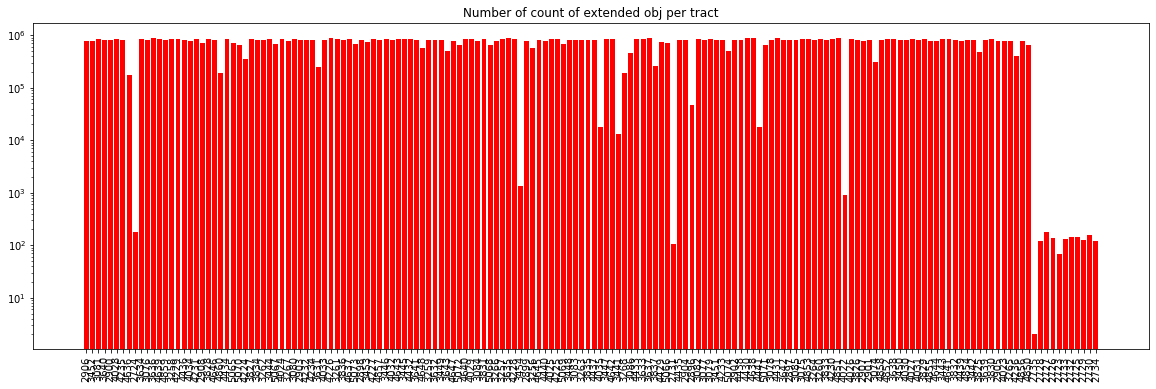

In [50]:
width=0.8
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(indexes,dp_stat["count"].values,width,color='red')
ax.set_xticks(indexes)
ax.set_title("Number of count of extended obj per tract")
xtickNames = ax.set_xticklabels(dp_stat["tract"].values)
plt.setp(xtickNames, rotation=90, fontsize=10)
plt.yscale('log')

The DM stack includes functionality to get the tract and patch number corresponding to a certain position `(RA,DEC)`. However, it is out of the scope of this tutorial.

Apache Spark provides `filter` mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset.
For the object catalog, the chunks are broken into `tract` and `patch`, and hence those are the `filters` you can use:

======= tract 2906 ================


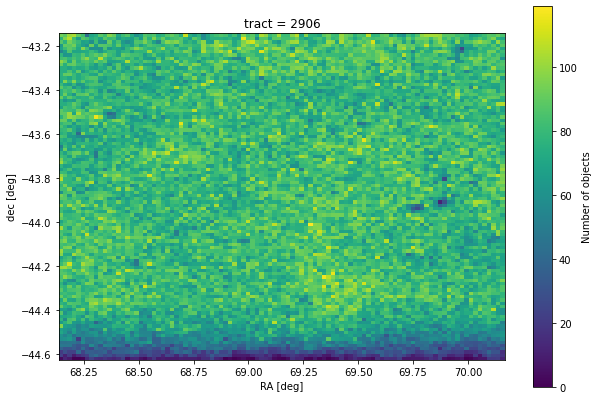

======= tract 3452 ================


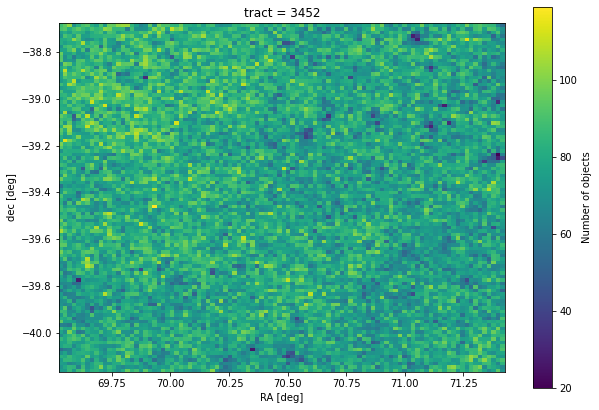

======= tract 3081 ================


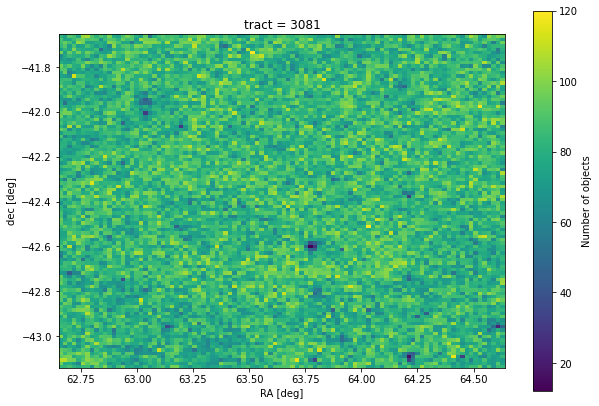

In [51]:
idx=0
for the_tract in dp_stat["tract"].values:
    selection_name = "tract == {}".format(the_tract)

    # Retrieve the ra,dec coordinates of all sources within tract number 4430
    data = df_gal.select('ra', 'dec').where(selection_name).collect()
    #data = df.select('ra', 'dec').collect()
    
    print("======= tract {} ================".format(the_tract))
    #data.describe().show()

    if dp_stat["count"].values[idx]>1e4:
    
        # `collect` returns list of list[ra, dec], so for 
        # plotting purpose we tranpose the output:
        ra, dec = np.transpose(data)

        # Plot a 2d histogram of sources
        plt.figure(figsize=(10,7))
        plt.hist2d(ra, dec, 100)
        plt.gca().set_aspect('equal')
        plt.colorbar(label='Number of objects')
        plt.xlabel('RA [deg]')
        plt.ylabel('dec [deg]');
        plt.title("tract = {}".format(the_tract))
        plt.show()
        
    idx+=1
    if idx>2:
        break

In [52]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
df_gal_healpix = df_gal.withColumn("ihealpix",pd_ang2pix(df_gal["ra"],df_gal["dec"]))

In [53]:
df_gal_healpix.printSchema()

root
 |-- I_flag: boolean (nullable = true)
 |-- I_flag_g: boolean (nullable = true)
 |-- I_flag_i: boolean (nullable = true)
 |-- I_flag_r: boolean (nullable = true)
 |-- I_flag_u: boolean (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- I_flag_z: boolean (nullable = true)
 |-- IxxPSF_pixel: double (nullable = true)
 |-- IxxPSF_pixel_g: double (nullable = true)
 |-- IxxPSF_pixel_i: double (nullable = true)
 |-- IxxPSF_pixel_r: double (nullable = true)
 |-- IxxPSF_pixel_u: double (nullable = true)
 |-- IxxPSF_pixel_y: double (nullable = true)
 |-- IxxPSF_pixel_z: double (nullable = true)
 |-- Ixx_pixel: double (nullable = true)
 |-- Ixx_pixel_g: double (nullable = true)
 |-- Ixx_pixel_i: double (nullable = true)
 |-- Ixx_pixel_r: double (nullable = true)
 |-- Ixx_pixel_u: double (nullable = true)
 |-- Ixx_pixel_y: double (nullable = true)
 |-- Ixx_pixel_z: double (nullable = true)
 |-- IxyPSF_pixel: double (nullable = true)
 |-- IxyPSF_pixel_g: double (nullable = true)
 

In [54]:
df_gal_healpix_small=df_gal_healpix.select('ra','dec','ihealpix')

In [55]:
df_gal_healpix_small.describe().show()

+-------+------------------+-------------------+------------------+
|summary|                ra|                dec|          ihealpix|
+-------+------------------+-------------------+------------------+
|  count|         112645553|          112645553|         112645553|
|   mean|61.943493855209525| -35.99918869451187| 2493221.155320077|
| stddev| 6.218407017828433|  4.963762304860995|110123.85901925545|
|    min| 49.49254691350636|-44.642587097415955|           2282843|
|    max| 74.21783862260499|-26.935087554628794|           2678580|
+-------+------------------+-------------------+------------------+



In [56]:
m=df_gal_healpix_small.groupBy('ihealpix').count()
m.show(5)

+--------+-----+
|ihealpix|count|
+--------+-----+
| 2653021| 5200|
| 2649047| 5401|
| 2651098| 5035|
| 2641122| 4819|
| 2628995| 4691|
+--------+-----+
only showing top 5 rows



In [ ]:
#m.orderBy('ihealpix', ascending=True).show(10)

In [60]:
# get to python world (to Pandas) : 
# note that here is the action (lazy evaluation so far)
p=m.toPandas()
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23571 entries, 0 to 23570
Data columns (total 2 columns):
ihealpix    23571 non-null int32
count       23571 non-null int64
dtypes: int32(1), int64(1)
memory usage: 276.3 KB


In [58]:
p

,ihealpix,count
0,2653021,5200
1,2651087,4592
2,2651098,5035
3,2614569,5241
4,2596134,5348
5,2606374,4787
6,2594156,4993
7,2585905,5130
8,2563434,4832
9,2581911,4956


/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


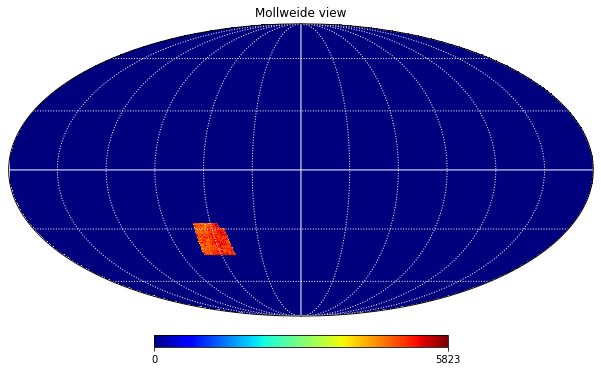

In [61]:
# the following doesn't has anything to do with spark (only Healpix)
hpMap = np.zeros(hp.nside2npix(nside))
#fill the map from the pandas object
hpMap[p['ihealpix'].values]=p['count'].values
#plot using standard healpy function
hp.mollview(hpMap,cmap="jet")
hp.graticule(color='white')

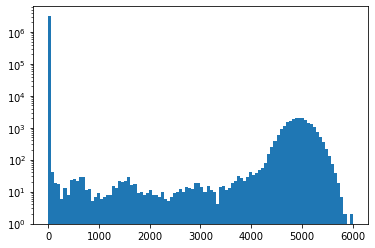

In [62]:
plt.hist(hpMap,bins=int(100))
plt.yscale('log')
plt.show()

In [63]:
cl = hp.anafast(hpMap)
ell = np.arange(len(cl))

Text(0.5, 1.0, 'DC2Run2.2i : $C_\\ell$ by healpix/anafast')

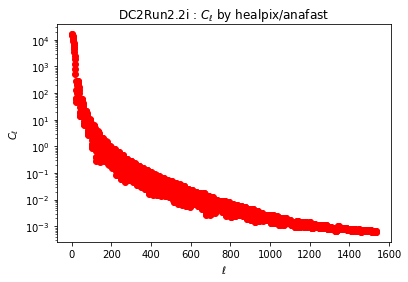

In [64]:
plt.plot(ell,cl,"ro")
plt.yscale('log')
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.title("{} : $C_\ell$ by healpix/anafast".format("DC2Run2.2i"))

In [65]:
lmax 

1536

In [66]:
hpMap.shape

(3145728,)